# Decision Trees & Random Forests to Predict Spam
- regression & classification trees
- random forests take the average prediction values by bagging (taking random samples from population with replacement) and feature randomization

### Decision Tree

In [41]:
library(tree)
library(ISLR)
library(readr)
library(caret)

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin



In [2]:
# Load data
head(spam_df)

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


word_make,word_address,word_all,word_3d,word_our,word_over,word_remove,word_internet,word_order,word_mail,...,char_semicolon,char_leftbrac,char_leftsquarebrac,char_exclaim,char_dollar,char_pound,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,1,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,3.756,61,278,1
1,1,1,0,1,1,1,1,0,1,...,0,1,0,1,1,1,5.114,101,1028,1
1,0,1,0,1,1,1,1,1,1,...,1,1,0,1,1,1,9.821,485,2259,1
0,0,0,0,1,0,1,1,1,1,...,0,1,0,1,0,0,3.537,40,191,1
0,0,0,0,1,0,1,1,1,1,...,0,1,0,1,0,0,3.537,40,191,1
0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,3.000,15,54,1


In [3]:
attach(spam_df)

In [4]:
# relabel spam column as yes/no
Spam = ifelse(spam==1, 'yes', 'no')
spam_df  = subset(spam_df, select = -c(spam))
spam_df = data.frame(spam_df, Spam)

head(spam_df)

word_make,word_address,word_all,word_3d,word_our,word_over,word_remove,word_internet,word_order,word_mail,...,char_semicolon,char_leftbrac,char_leftsquarebrac,char_exclaim,char_dollar,char_pound,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Spam
0,1,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,3.756,61,278,yes
1,1,1,0,1,1,1,1,0,1,...,0,1,0,1,1,1,5.114,101,1028,yes
1,0,1,0,1,1,1,1,1,1,...,1,1,0,1,1,1,9.821,485,2259,yes
0,0,0,0,1,0,1,1,1,1,...,0,1,0,1,0,0,3.537,40,191,yes
0,0,0,0,1,0,1,1,1,1,...,0,1,0,1,0,0,3.537,40,191,yes
0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,3.000,15,54,yes


In [5]:
# Create decision Tree
tree.spam = tree(Spam~. , data = spam_df)
summary(tree.spam)


Classification tree:
tree(formula = Spam ~ ., data = spam_df)
Variables actually used in tree construction:
 [1] "char_exclaim"               "word_remove"               
 [3] "word_george"                "word_money"                
 [5] "word_hp"                    "capital_run_length_longest"
 [7] "char_dollar"                "capital_run_length_average"
 [9] "word_free"                  "word_edu"                  
Number of terminal nodes:  14 
Residual mean deviance:  0.533 = 2445 / 4587 
Misclassification error rate: 0.1072 = 493 / 4601 

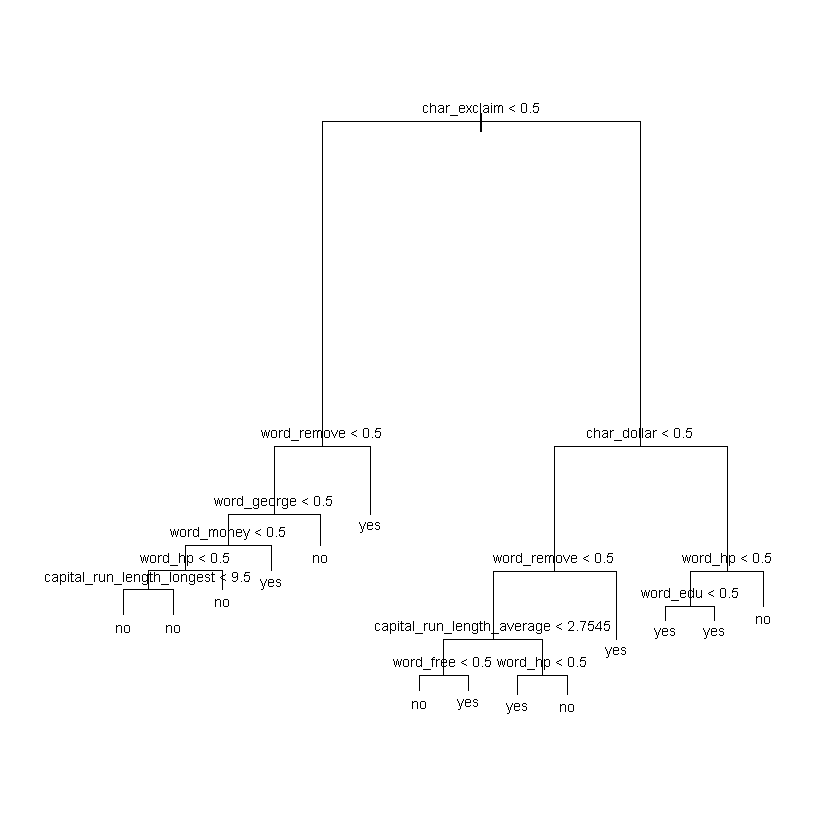

In [6]:
plot(tree.spam)
text(tree.spam, pretty = 0, cex = 0.7)

In [7]:
# split data into training and testing set
set.seed(3)
train = sample(1: nrow(spam_df), 200) # random sample of size 200

spam.testing = spam_df[-train,] 
Spam.test = Spam[-train] # Spam column without training data

tree.spam = tree(Spam ~. , data = spam_df, subset = train) # tree model
tree.pred = predict(tree.spam, spam.testing, type = 'class') # make prediction with tree & testing data

# compare predictions to actual test data
table(tree.pred, Spam.test)


         Spam.test
tree.pred   no  yes
      no  2239  354
      yes  431 1377

In [8]:
(2239+1377)/4601

[1] 0.7859161

In [9]:
set.seed(4)

# use classification error to guide cross validation and pruning
cv.spam = cv.tree(tree.spam, FUN = prune.misclass)
cv.spam

$size
[1] 13  8  7  4  3  2  1

$dev
[1] 30 30 30 31 34 47 83

$k
[1] -Inf    0    1    2    4    9   48

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

         Spam.test
spam.pred   no  yes
      no  2289  303
      yes  381 1428

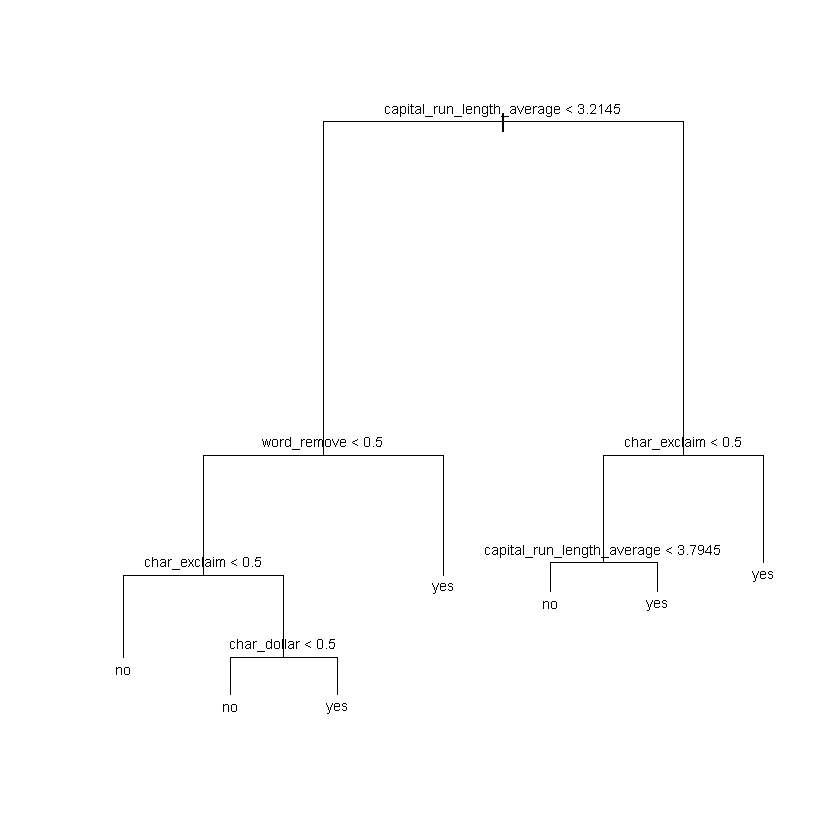

In [10]:
# prune with 7 node tree

prune.spam = prune.misclass(tree.spam, best = 7)
plot(prune.spam)
text(prune.spam,pretty=0, cex = 0.7)

spam.pred = predict(prune.spam, spam.testing, type = 'class')
table(spam.pred, Spam.test)

In [11]:
(2289 + 1428)/4601

[1] 0.8078679

### Random Forest

In [45]:
library(randomForest)

set.seed(5)

rf.spam = randomForest(Spam ~ . , data = spam_df, subset = train)
rf.spam


Call:
 randomForest(formula = Spam ~ ., data = spam_df, subset = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 7%
Confusion matrix:
     no yes class.error
no  111   7  0.05932203
yes   7  75  0.08536585

In [46]:
(111+75)/(111+75+7+7)

[1] 0.93

In [42]:
varImp(rf.spam)

,Overall
word_make,0.51399258
word_address,0.55744114
word_all,0.98154495
word_3d,0.15875315
word_our,2.46976819
word_over,0.23581373
word_remove,6.03578336
word_internet,1.75171624
word_order,0.26848368
word_mail,0.63868392


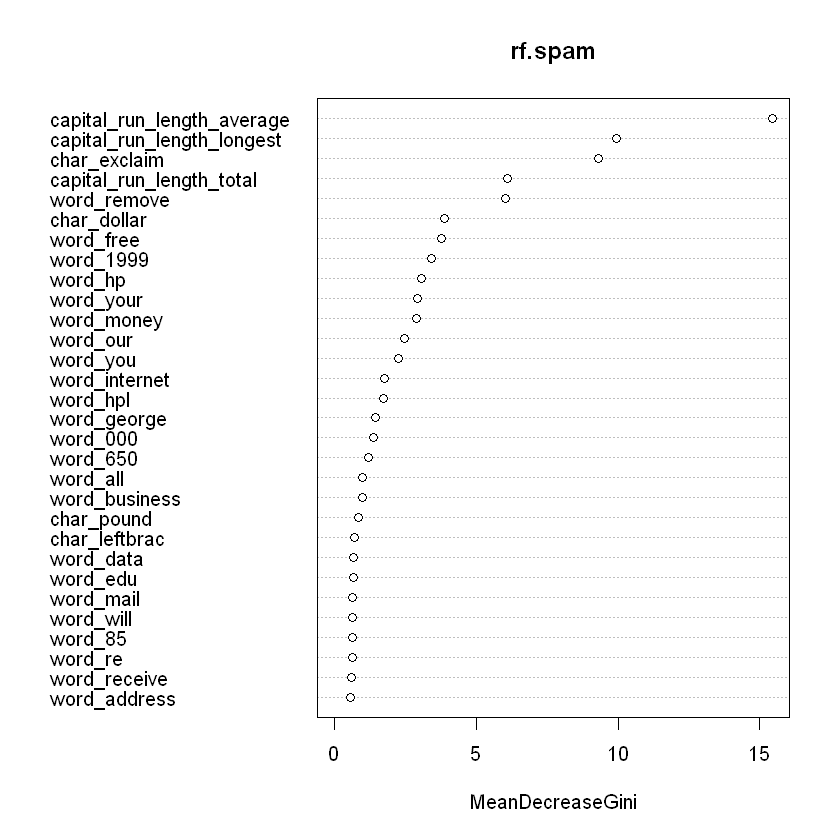

In [43]:
varImpPlot(rf.spam,type=2)